<a href="https://colab.research.google.com/github/SoNdA11/Appoia/blob/main/projeto_ia2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Célula 1: Conexão e Carregamento de Dados
Nesta etapa, conectamos o ambiente de execução ao Google Drive para acessar o arquivo zip do dataset de forma persistente. Isso evita ter que fazer upload manual toda vez. O código verifica se o arquivo existe, limpa versões antigas para evitar conflitos e descompacta as imagens no ambiente temporário do Linux.

In [1]:
import os
import shutil
from google.colab import drive

print("--- CONECTANDO AO GOOGLE DRIVE ---")

# 1. Monta o Drive
drive.mount('/content/drive')

# Caminho onde você salvou o arquivo no Drive
zip_path_no_drive = '/content/drive/My Drive/Datasets/archive.zip'

# 2. Verifica se o arquivo existe lá
if not os.path.exists(zip_path_no_drive):
    print(f"ERRO: Não achei o arquivo em '{zip_path_no_drive}'")
    print("DICA: Verifique se o nome da pasta ou do arquivo estão certos no seu Drive.")
else:
    print("Arquivo encontrado no Drive! Copiando e descompactando...")

    # 3. Limpa a pasta antiga
    if os.path.exists('pokemon_species_data'):
        shutil.rmtree('pokemon_species_data')

    # 4. Descompacta
    # Estamos descompactando direto do Drive para o Colab
    !unzip -q "{zip_path_no_drive}" -d pokemon_species_data

    print("Sucesso! Dataset pronto para uso.")

--- CONECTANDO AO GOOGLE DRIVE ---
Mounted at /content/drive
Arquivo encontrado no Drive! Copiando e descompactando...
Sucesso! Dataset pronto para uso.


# Célula 2: Preparação do Dataset Completo
Aqui fazemos a engenharia de dados. O script localiza automaticamente a pasta raiz onde as imagens foram extraídas (já que a estrutura do zip pode variar). Diferente da versão anterior, agora não filtramos apenas os famosos. O código itera sobre todas as pastas encontradas e prepara todas as classes de Pokémons disponíveis para o treinamento, garantindo que o modelo seja capaz de reconhecer todo o conjunto de dados.

In [2]:
import shutil
import os

# --- BUSCA AUTOMÁTICA DA PASTA ---
print("Localizando onde as pastas dos Pokémons foram parar...")

source_dir = None
# O os.walk vai entrar em todas as subpastas até achar o Pikachu
# Usamos o Pikachu como referência para saber que chegamos na pasta certa
for root, dirs, files in os.walk("pokemon_species_data"):
    if "Pikachu" in dirs:
        source_dir = root
        print(f"ACHEI! As imagens estão em: {source_dir}")
        break

if source_dir is None:
    raise SystemExit("ERRO: Descompactou, mas não achei a pasta 'Pikachu'. O zip pode estar vazio.")

# --- CONFIGURAÇÃO ---
working_dir = 'dataset_final'

# Limpeza da pasta de trabalho anterior
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
os.makedirs(working_dir)

print(f"\nPreparando TODOS os Pokémons do dataset...")

todas_pastas = os.listdir(source_dir)
count = 0

for item in todas_pastas:
    src_path = os.path.join(source_dir, item)
    dst_path = os.path.join(working_dir, item)

    if os.path.isdir(src_path):
        shutil.copytree(src_path, dst_path)
        count += 1

print(f"Sucesso! {count} espécies de Pokémon preparadas na pasta '{working_dir}'.")

Localizando onde as pastas dos Pokémons foram parar...
ACHEI! As imagens estão em: pokemon_species_data/PokemonData

Preparando TODOS os Pokémons do dataset...
Sucesso! 150 espécies de Pokémon preparadas na pasta 'dataset_final'.


# Célula 3: Treinamento da Rede Neural (CNN)
Esta é a etapa principal. Definimos uma Rede Neural Convolucional (CNN).

Pré-processamento: As imagens são redimensionadas para 128x128 pixels.

Data Augmentation: Aplicamos rotações e zoom aleatórios para evitar que a IA 'decore' as imagens (overfitting).

Arquitetura: Usamos 3 camadas de convolução (Conv2D) para extrair características visuais, seguidas de camadas de MaxPooling para reduzir a dimensão.

Treinamento: A rede treina por 25 épocas. Como agora temos muito mais classes (aprox 150), o treinamento será mais longo e o gráfico de acurácia subirá mais devagar.

Carregando dataset completo...
Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.
Total de Classes encontradas: 150
Epoch 1/35
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.0095 - loss: 5.0198 - val_accuracy: 0.0176 - val_loss: 4.7967
Epoch 2/35
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0213 - loss: 4.7478 - val_accuracy: 0.0667 - val_loss: 4.3056
Epoch 3/35
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0433 - loss: 4.3877 - val_accuracy: 0.1188 - val_loss: 3.9147
Epoch 4/35
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0713 - loss: 4.1005 - val_accuracy: 0.1723 - val_loss: 3.6171
Epoch 5/35
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1163 - loss: 3.8101 - val_accuracy: 0.2243 - val_loss: 3.3536
Epoch 6/35
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1423 - loss: 3.5716 - val_accuracy: 0.2698 - val_loss: 3.0887
Epoch 7/35

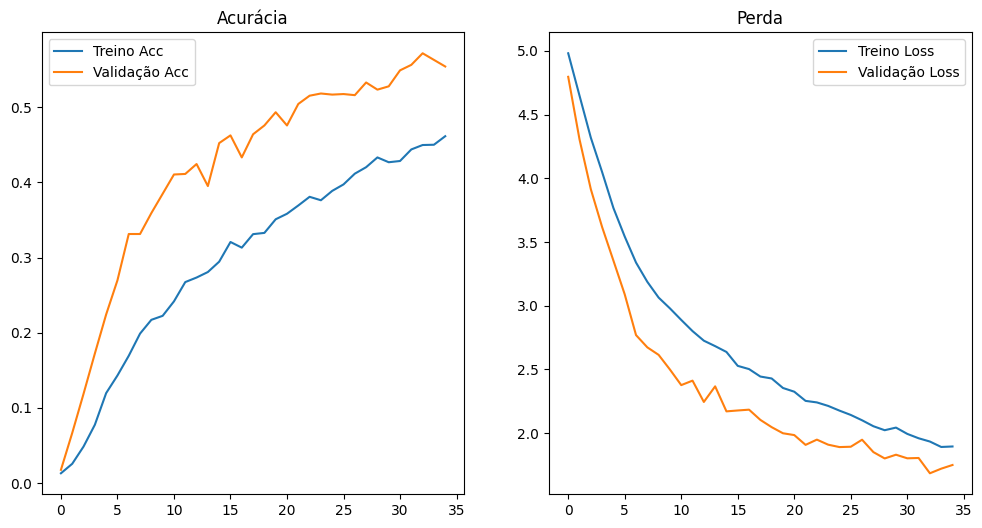

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Configurações
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 35
DATA_DIR = 'dataset_final'

# Carregar dados (Treino 80% / Validação 20%)
print("Carregando dataset completo...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=123,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=123,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Total de Classes encontradas: {len(class_names)}")

# Otimização de performance (Cache na memória)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation (Variações artificiais nas imagens)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

# Modelo CNN
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)), # Normaliza pixels (0 a 1)
    data_augmentation,

    # Extração de Características
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Classificação
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Desliga neurônios aleatórios para forçar aprendizado
    layers.Dense(len(class_names)) # Camada final com o número total de Pokémons
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Treino
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# Geração de Gráficos para o Artigo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino Acc')
plt.plot(epochs_range, val_acc, label='Validação Acc')
plt.title('Acurácia')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino Loss')
plt.plot(epochs_range, val_loss, label='Validação Loss')
plt.title('Perda')
plt.legend()
plt.show()

model.save('modelo_pokemon_completo.keras')

# Célula 3 com o transfer learning

Em vez de treinar uma rede do zero, vamos pegar um "cérebro" de IA que já foi treinado pelo Google em milhões de imagens (chamado MobileNetV2) e ensinar ele apenas a diferenciar os Pokémons. Com o MobileNetV2 aumenta a acurácia.

Isso se chama Transfer Learning. A rede já sabe identificar bordas, formas e texturas; nós só vamos "afinar" o conhecimento dela.

Carregando dataset...
Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.
Baixando o cérebro da MobileNetV2...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 150)            │       192,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,450,134 (9.35 MB)

 Trainable params: 192,150 (750.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Iniciando Transfer Learning...
Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.0095 - loss: 5.7171 - val_accuracy: 0.0425 - val_loss: 4.8559
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.0500 - loss: 4.7775 - val_accuracy: 0.1114 - val_loss: 4.3022
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1055 - loss: 4.1935 - val_accuracy: 0.1891 - val_loss: 3.8364
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.1909 - loss: 3.6782 - val_accuracy: 0.2647 - val_loss: 3.4512
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2795 - loss: 3.2144 - val_accuracy: 0.3270 - val_loss: 3.1465
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3643 - loss: 2.8747 - val_accuracy: 0.3739 - val_loss: 2.8926
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4178 - loss: 2.6293 - val_accuracy: 0.4289 - val_loss: 2.6852
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 

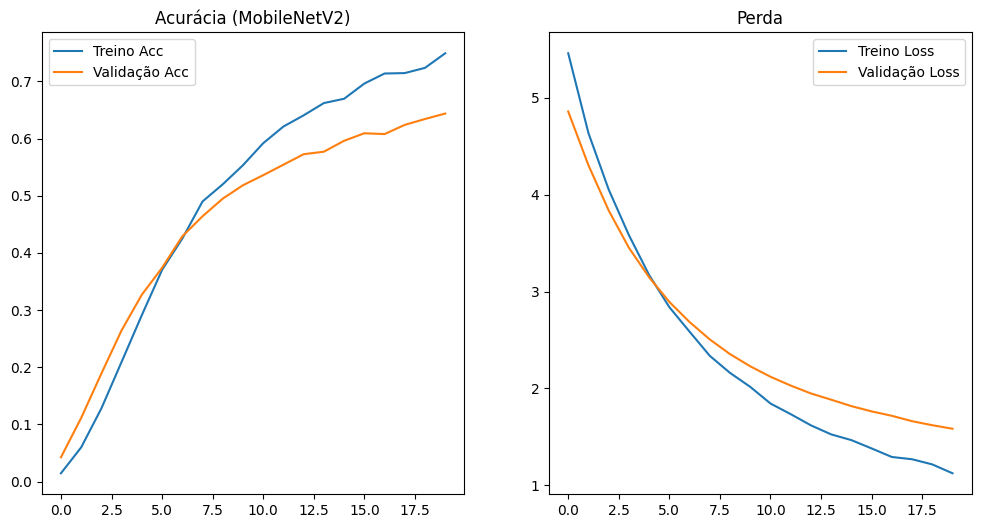

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Configurações
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20  # Com Transfer Learning, precisamos de menos épocas
DATA_DIR = 'dataset_final'

# Carregar dados
print("Carregando dataset...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=123,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=123,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Otimização
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2), # Adicionei contraste para ajudar
])

# --- TRANSFER LEARNING ---
print("Baixando o cérebro da MobileNetV2...")

# 1. Baixamos o modelo pré-treinado (MobileNetV2) sem a parte final (include_top=False)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Congelamos o modelo base para não estragar o que ele já sabe
base_model.trainable = False

# 3. Criamos o nosso modelo montado em cima do MobileNetV2
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
# O pré-processamento específico da MobileNet é OBRIGATÓRIO
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Resume as características
x = layers.Dropout(0.2)(x) # Evita overfitting
outputs = layers.Dense(num_classes)(x) # Camada final com 150 classes

model = models.Model(inputs, outputs)

# Compilação
# Usamos um learning rate menor para não ser brusco
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

# Treino
print("Iniciando Transfer Learning...")
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# Gráficos
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino Acc')
plt.plot(epochs_range, val_acc, label='Validação Acc')
plt.title('Acurácia (MobileNetV2)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino Loss')
plt.plot(epochs_range, val_loss, label='Validação Loss')
plt.title('Perda')
plt.legend()
plt.show()

model.save('modelo_pokemon_mobilenet.keras')

# Célula 4: Visualização dos Resultados
Para validar visualmente o modelo, pegamos um lote aleatório de imagens que a IA nunca viu durante o treino (conjunto de validação). O código realiza a predição e compara com o rótulo real. Se o título estiver verde, a IA acertou; se vermelho, errou. Exibimos também a porcentagem de confiança da decisão.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


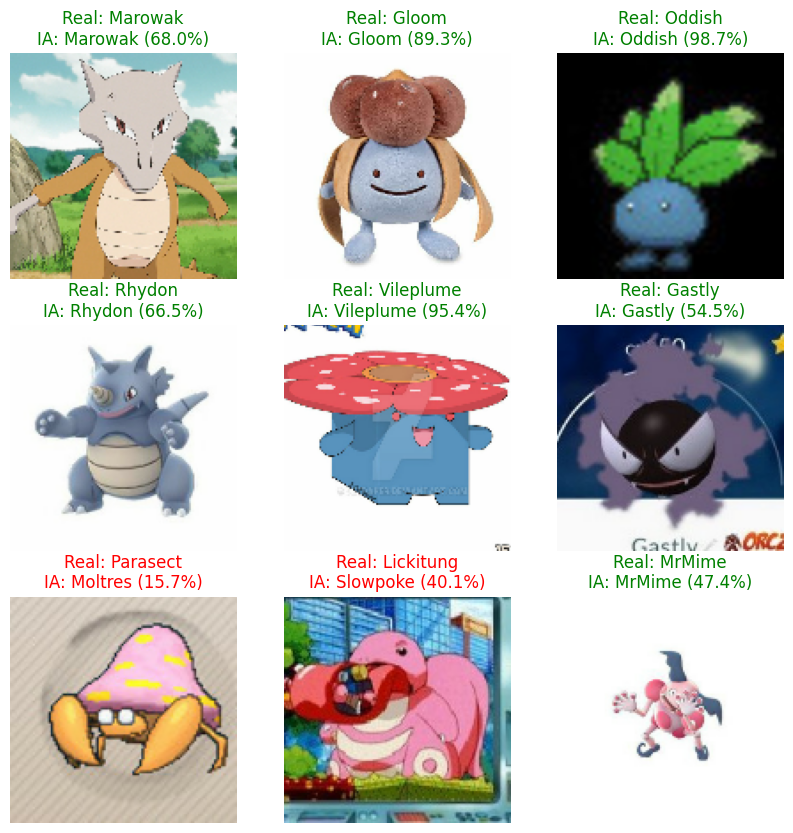

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Pega um lote de imagens do conjunto de validação
# (O take(1) pega 32 imagens, mas vamos mostrar só 9)
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Prepara a imagem
    img = image_batch[i].numpy().astype("uint8")
    label_real = class_names[label_batch[i]]

    # --- A PREDIÇÃO ACONTECE AQUI ---
    # Expande a dimensão para (1, 128, 128, 3) pois o modelo espera um lote
    img_array = tf.expand_dims(image_batch[i], 0)
    predictions = model.predict(img_array)

    # Transforma os números brutos em porcentagem
    score = tf.nn.softmax(predictions[0])

    # Pega o nome da classe com maior nota
    pred_label = class_names[np.argmax(score)]
    confianca = 100 * np.max(score)

    # Mostra a imagem
    plt.imshow(img)

    # Cor do título: Verde se acertou, Vermelho se errou
    cor = "green" if pred_label == label_real else "red"

    plt.title(f"Real: {label_real}\nIA: {pred_label} ({confianca:.1f}%)", color=cor)
    plt.axis("off")

plt.show()

# Célula 5: Teste Manual (Upload)
Esta etapa permite testar o modelo 'no mundo real'. Podemos baixar qualquer imagem da internet, fazer o upload para o Colab, e o código tratará a imagem (redimensionando e convertendo para array numérico) para que a Rede Neural faça sua previsão.

--- TESTE COM UPLOAD ---
Faça upload de uma imagem de Pokémon (jpg ou png):


Saving images.jpg to images.jpg

Processando: images.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


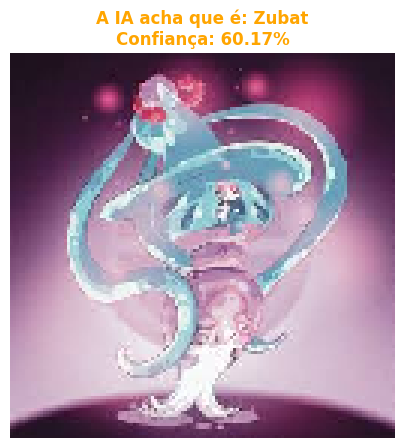

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from google.colab import files

print("--- TESTE COM UPLOAD ---")
print("Faça upload de uma imagem de Pokémon (jpg ou png):")
uploaded = files.upload()

# Verifica se o modelo e as classes existem na memória
if 'model' not in globals() or 'class_names' not in globals():
    print("\n[ERRO] O modelo ou os nomes das classes não foram encontrados.")
    print("DICA: Rode a Célula 3 (Treinamento) novamente ou carregue o modelo salvo.")
else:
    for fn in uploaded.keys():
        print(f"\nProcessando: {fn}...")

        try:
            # 1. Carrega a imagem forçando RGB (evita erro com PNG transparente)
            # O target_size DEVE ser o mesmo usado no treino (128x128)
            img = image.load_img(fn, target_size=(128, 128), color_mode='rgb')

            # 2. Converte para array numérico (Height, Width, 3)
            img_array = image.img_to_array(img)

            # 3. Cria o lote (Batch) adicionando uma dimensão extra -> (1, 128, 128, 3)
            img_array = np.expand_dims(img_array, axis=0)

            # 4. Predição
            # Nota: Não dividimos por 255 aqui porque a camada 'Rescaling'
            # já está dentro do seu modelo (ver Célula 3).
            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            # 5. Resultados
            predicted_class = class_names[np.argmax(score)]
            confidence = 100 * np.max(score)

            # Mostra a imagem e o resultado
            plt.figure(figsize=(5, 5))
            plt.imshow(img)

            # Título colorido: Verde se confiança alta (>70%), Amarelo se média, Vermelho se baixa
            cor_texto = 'green' if confidence > 70 else 'orange'
            if confidence < 50: cor_texto = 'red'

            plt.title(f"A IA acha que é: {predicted_class}\nConfiança: {confidence:.2f}%",
                      color=cor_texto, fontweight='bold')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Erro ao processar a imagem: {e}")